# 3. Linear Models for Classification

### *Table of Contents*
* 4.1 [Discriminant Functions](#4.1-Discriminant-Functions)
    * 4.1.3 [Least squares for classification](#4.1.3-Least-squares-for-classification)
    * 4.1.4 [Fisher's linear discriminant](#4.1.4-Fisher's-linear-discriminant)
    * 4.1.7 [The perceptron algorithm](#4.1.7-The-perceptron-algorithm)
* 4.2 [Probabilistic Generative Models](#4.2-Probabilistic-Generative-Models)
* 4.3 [Probabilistic Discriminative Models](#4.3-Probabilistic-Discriminative-Models)
* 4.4 [Laplace Approximation](#4.4-Laplace-Approximation)
* 4.5 [Bayesian Logistic Regression](#4.5-Bayesian-Logistic-Regression)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from prml.preprocessing import LinearFeature
from prml.linear import LeastSquaresClassifier
from prml.linear import FisherLinearDiscriminant
from prml.distribution import Gaussian

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide = 'ignore', invalid='ignore')

# Enable higher resolution plots
%config InlineBackend.figure_format = 'retina'

The goal in classification is to take an input vector $\mathbf{x}$ and assign it to one of $K$ discrete classes $\mathcal{C}_k$, where $k=1\dots,K$. The input space is thereby divided into *decision regions* whose boundaries are called *decision boundaries* or *decision surfaces*. Linear models define decision surfaces as linear functions of the input vector $\mathbf{x}$ and hence are defined by $(D-1)$-dimensional hyperplanes inside the $D$-dimensional space. Datasets whose classes can be separated exactly by linear decision surfaces are called *linearly separable*.

There are three distinct approaches to the classification problem:

1. Discriminant functions that directly assign each input vector $\mathbf{x}$ to a class.
2. Models that directly learn the conditional probability $p(\mathcal{C}_k|\mathbf{x})$ using parametric modelling.
3. Generative approaches that model the class conditional density $p(\mathbf{x}|\mathcal{C}_k)$, and the prior probabilities $p(\mathcal{C}_k)$ for the classes. Then they derive the posterior using the Bayes theorem.

In the linear regression models, the model prediction $y(\mathbf{x}, \mathbf{w})$ was given by a linear function of the parameters $\mathbf{w}$. For classification problems, however, we wish to predict discrete class labels. To that end, we consider a generalization of the above model in which we transform the linear function using a nonlinear function $f(\cdot)$ so that

$$
y(\mathbf{x}) = f(\mathbf{w}^T\mathbf{x} + w_0)
$$

In machine learning, the function $f$ is known as an *activation function*.

## 4.1 Discriminant Functions

A discriminant is a function that assigns one of $K$ classes to an input vector $\mathbf{x}$. *Linear discriminants* define decision surfaces that are hyperplanes.


### 4.1.1 Two Classes

The simplest linear discriminant function is obtained by taking a linear function of the input vector so that,

$$
y(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + w_0
$$

where $\mathbf{w}$ is a *weight vector* and $w_0$ is a *bias* (the negative of the bias is also called *threshold*). Then, an input $\mathbf{x}$ is assigned to a class $\mathcal{C}_1$ if $y(\mathbf{x})\geq0$ and to class $\mathcal{C}_2$ otherwise. Thus, the decision boundary is defined by $y(\mathbf{x})=0$.

Consider two points $\mathbf{x}_A$ and $\mathbf{x}_B$ onto the decision surface. Then, $y(\mathbf{x}_A)=y(\mathbf{x}_B)=0 \Leftrightarrow \mathbf{w}^T(\mathbf{x}_A-\mathbf{x}_B)=0$, which implies that the vector $\mathbf{w}$ is orthogonal to every vector lying in the decision surface as depicted below:

<img src="../images/fg4_1.png" width="400"/>

Note that for more than two classes ($K>2$), a *one-vs-the-rest* classifier can be used in order to avoid regions of input space that are ambiguously classified. The linear function of each class takes the form $y_k(\mathbf{x}) = \mathbf{w}_k^T\mathbf{x} + w_{k0}$, and assigns a point $\mathbf{x}$ to class $\mathcal{C}_k$ if $y_k(\mathbf{x}) > y_j(\mathbf{x}) \; \forall j\neq k$.

In the following sections we explore three approaches to learning the parameters of linear discriminant functions:

1. Least squares
2. Fisher's linear discriminant
3. Perceptron algorithm

### 4.1.3 Least squares for classification

In [Chapter 3](ch3_linear_models_for_regression.ipynb), we minimized the sum-of-squared error function led to a closed-form solution for the parameter values. Can we apply the same principle to classification problems?

Consider a general classification problem having $K$ classes, using a $1$-of-$K$ binary coding scheme or *one-hot* encoding for the target vector. Each class $\mathcal{C}_k$ is described by its own linear model $y_k$. We can group these models together using vector notation so that

$$
\mathbf{y}(\mathbf{x}) = \mathbf{\tilde{W}}^T\mathbf{\tilde{x}}
$$

where $\mathbf{\tilde{W}}$ is a matrix whose $k^{th}$ column comprises the $D+1$-dimensional vector $\mathbf{\tilde{w}}_k=(w_{k0},\mathbf{w}_k^T)^T$ and $\mathbf{\tilde{x}}$ is the augmented vector $(1, \mathbf{\tilde{x}}^T)^T$. The parameter matrix $\mathbf{\tilde{W}}$ is determined by minimizing the sum-of-squares error function, as presented in [Chapter 3](ch3_linear_models_for_regression.ipynb). Thus, the solution for $\mathbf{\tilde{W}}$ is obtained from

$$
\mathbf{\tilde{W}} = (\mathbf{\tilde{X}}^T\mathbf{\tilde{X}})^{-1}\mathbf{\tilde{X}}^T\mathbf{T}
$$

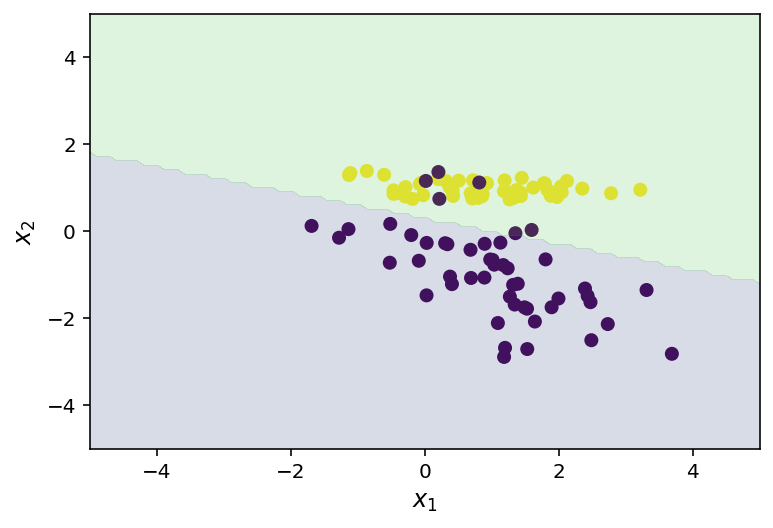

In [2]:
# number of training points
N = 100

x_train, t = make_classification(
    n_features=2, 
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    n_samples=N
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1, x2]).reshape(2, -1).T

feature = LinearFeature()
x_train_linear = feature.transform(x_train)
x_test_linear = feature.transform(x_test)

model = LeastSquaresClassifier()
model.fit(x_train_linear, t)
predicted = model.predict(x_test_linear)

plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.xlabel("$x_1$", fontsize=12); plt.ylabel("$x_2$", fontsize=12)
plt.show()

The least-squares approach gives an exact closed-form solution for the discriminant function parameters. However, even as a discriminant function (making decisions directly) it suffers from some problems. We already know that least-squares solutions lack robustness to outliers, and this applies equally to classification, as depicted in the following figure. Note that the additional outlier data points produce a change in the location of the decision boundary, even though these point would be correctly classified by the original decision boundary. The sum-of-squares error function penalizes predictions that are *too correct* in that they lie a long way on the correct side of the decision boundary.

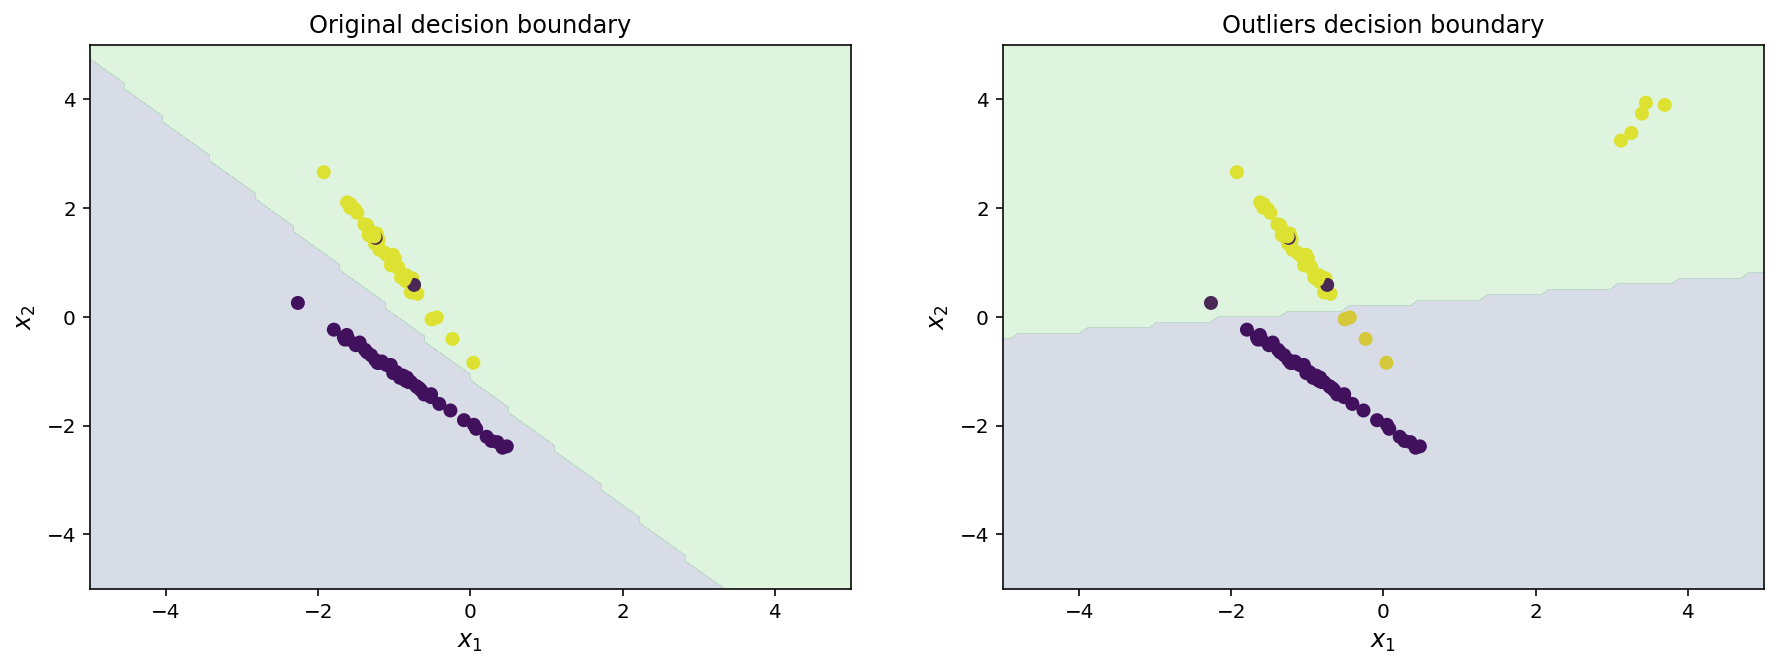

In [3]:
# number of training points
N = 100

# number of outlier points
n_outliers = 5

x_train, t = make_classification(
    n_features=2, 
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    n_samples=N,
    random_state=12
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1, x2]).reshape(2, -1).T

outliers = np.random.random_sample((n_outliers, 2)) + 3
x_train_outliers = np.vstack((x_train, outliers))
t_outliers = np.hstack((t, np.ones(n_outliers, dtype=int)))

feature = LinearFeature()
x_train_linear = feature.transform(x_train)
x_train_linear_outliers = feature.transform(x_train_outliers)
x_test_linear = feature.transform(x_test)

model = LeastSquaresClassifier()
model.fit(x_train_linear, t)
predicted = model.predict(x_test_linear)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.xlabel("$x_1$", fontsize=12); plt.ylabel("$x_2$", fontsize=12)
plt.title("Original decision boundary")

model.fit(x_train_linear_outliers, t_outliers)
predicted_outliers = model.predict(x_test_linear)

plt.subplot(1, 2, 2)
plt.scatter(x_train_outliers[:, 0], x_train_outliers[:, 1], c=t_outliers)
plt.contourf(x1, x2, predicted_outliers.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.xlabel("$x_1$", fontsize=12); plt.ylabel("$x_2$", fontsize=12)
plt.title("Outliers decision boundary")

plt.show()

The failure of least squares should not surprise us since it corresponds to maximum likelihood under the assumption of a Gaussian conditional distribution, whereas binary target vectors clearly do not have a Gaussian distribution.

### 4.1.4 Fisher's linear discriminant

Consider a two-class problem in which there are $N_1$ points of class $\mathcal{C}_1$ and $N_2$ points from class $\mathcal{C}_2$, so that the mean vectors of the two classes are given by

$$
\mathbf{m}_1 = \frac{1}{N_1}\sum_{n\in\mathcal{C}_1}\mathbf{x}_n, \qquad\qquad \mathbf{m}_2 = \frac{1}{N_2}\sum_{n\in\mathcal{C}_2}\mathbf{x}_n
$$

Then, the simplest measure of separation of the classes, when projected onto $\mathbf{w}$, is the separation of the projected class means. This suggests that we might choose $\mathbf{w}$ so as to maximize 

$$
m_2 - m_1 = \mathbf{w}^T(\mathbf{m}_2 - \mathbf{m}_1)
$$

where

$$
m_k = \mathbf{w}^T\mathbf{m}_k
$$

is the mean of the projected data from class $\mathcal{C}_k$.

The idea proposed by Fisher is to maximize the function that gives a large separation between the projected class means while also giving a small variance within each class, thereby minimizing the class overlap. The within-class variance of the projected data from class $\mathcal{C}_k$ is given by,

$$
s_k^2 = \sum_{n\in\mathcal{C}_k} (y_n - m_k)^2
$$

where $y_n = \mathbf{w}^T\mathbf{x}_n$ is the projected data point in the one-dimentional space. We can further define the total within-class variance for the whole data set to be simply $s_1^2 + s_2^2$. Then, the Fisher criterion is defined as the ratio of the *between-class* variance to the *within-class* variance as follows,

$$
J(\mathbf{w}) = \frac{(m_2-m_1)^2}{s_1^2+s_2^2}
$$

In order to explicitly show the dependence on $\mathbf{w}$, we may rewrite $J(\mathbf{w})$, using $(4.20)$, $(4.23)$, and $(4.24)$, as follows,

$$
\begin{align*}
J(\mathbf{w}) &= \frac{(m_2-m_1)^2}{s_1^2+s_2^2}\\
&= \frac{(\mathbf{w}^T\mathbf{m}_2-\mathbf{w}^T\mathbf{m}_1)^2}{\sum_{n\in\mathcal{C}_k} (y_n - m_1)^2 + \sum_{n\in\mathcal{C}_k} (y_n - m_2)^2}\\
&= \frac{(\mathbf{w}^T(\mathbf{m}_2-\mathbf{m}_1))^2}{\sum_{n\in\mathcal{C}_k} (\mathbf{w}^T(\mathbf{x}_n - \mathbf{m}_1))^2 + \sum_{n\in\mathcal{C}_k} (\mathbf{w}^T(\mathbf{x}_n - \mathbf{m}_2))^2}\\
&= \frac{\mathbf{w}^T(\mathbf{m}_2-\mathbf{m}_1)^2\mathbf{w}}{\mathbf{w}^T\big(\sum_{n\in\mathcal{C}_k} (\mathbf{x}_n - \mathbf{m}_1)^2 + \sum_{n\in\mathcal{C}_k} (\mathbf{x}_n - \mathbf{m}_2)^2\big)\mathbf{w}}\\
&=\frac{\mathbf{w}^T\mathbf{S}_B\mathbf{w}}{\mathbf{w}^T\mathbf{S}_W\mathbf{w}}
\end{align*}
$$

Then, by computing the derivative with respect to $\mathbf{w}$, we find that $J(\mathbf{w})$ is maximized when,

$$
(\mathbf{w}^T\mathbf{S}_B\mathbf{w})\mathbf{S}_W\mathbf{w} = (\mathbf{w}^T\mathbf{S}_W\mathbf{w})\mathbf{S}_B\mathbf{w} \Leftrightarrow \mathbf{w} \propto \mathbf{S}_W^{-1}(\mathbf{m}_2-\mathbf{m}-1)
$$

This result is known as the *Fisher's linear discriminant*. To that end, the projected data are compared against a threshold $y_0$ and classified as belonging to class $\mathcal{C}_1$ if $y(\mathbf{x}) \geq y_0$, and to class $\mathcal{C}_2$ otherwise.

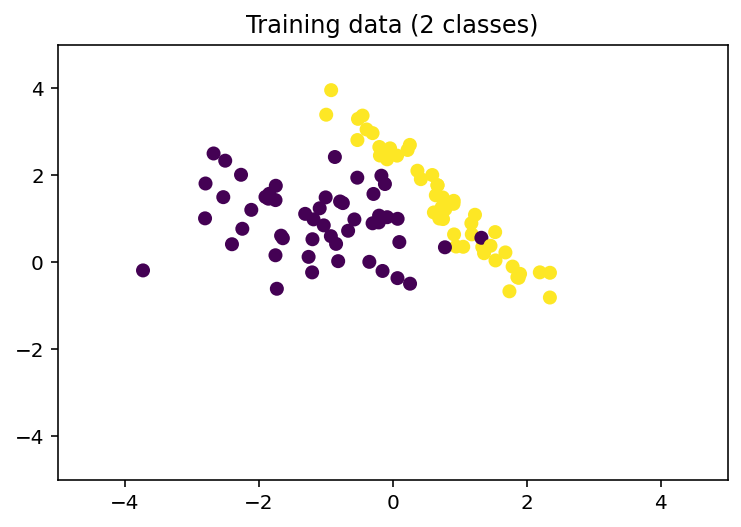

In [4]:
# number of training points
N = 100

x_train, t = make_classification(
    n_features=2, 
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    n_samples=N,
    random_state=15
)

x1, x2 = np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
x_test = np.array([x1, x2]).reshape(2, -1).T

plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.title("Training data (2 classes)")

plt.show()

One way of choosing the threshold $y_0$ is to model the class-conditional densities (one per class) $p(y|\mathcal{C}_k)$ as Gaussian distributions, then estimate their parameters using maximum likelihood, and finally, estimate the optimal threshold using decision theory. In the case of binary classification, we can equate the Gaussian functions and solve for $\mathbf{x}$. The result is a quadratic equation having coefficients relating to the gaussian means and variances.

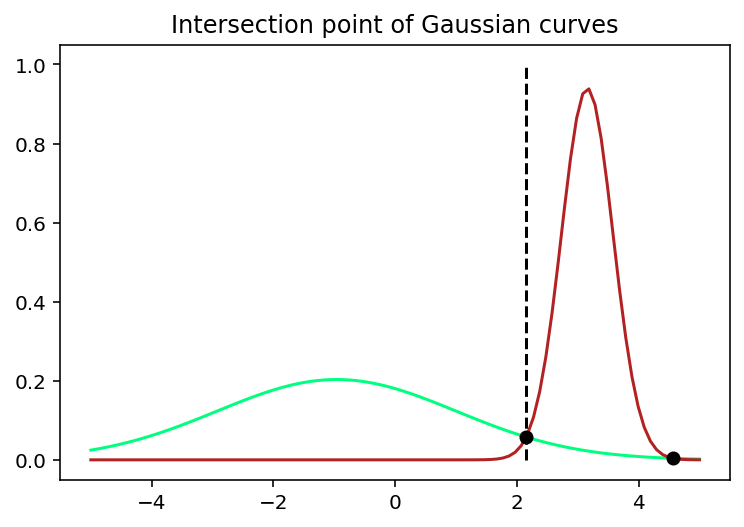

In [5]:
# split data points according to the classes
x_0 = x_train[t == 0]
x_1 = x_train[t == 1]

model = FisherLinearDiscriminant()
model.fit(x_train, t)

# create a Gaussian distribution per class
g0 = Gaussian()
g0.ml(x_0 @ model._w)
g1 = Gaussian()
g1.ml(x_1 @ model._w)

root = np.roots([
    g1.var - g0.var,
    2 * (g0.var * g1.mu - g1.var * g0.mu),
    g1.var * g0.mu ** 2 - g0.var * g1.mu ** 2 - g1.var * g0.var * np.log(g1.var / g0.var),
])

x = np.linspace(-5, 5, N)
plt.plot(x, g0.pdf(x), 'springgreen')
plt.plot(x, g1.pdf(x), 'firebrick')
plt.plot(root[0], g0.pdf(root[0]), 'ko') 
plt.plot(root[1], g0.pdf(root[1]), 'ko')
plt.plot(np.zeros(x.size) + root[1], np.linspace(0, 1, N), 'k--')
plt.title("Intersection point of Gaussian curves")

plt.show()

The figures below compares the optimal threshold against the naive zero threshold. Note that the selection of the decision threshold is crucial for an effective model.

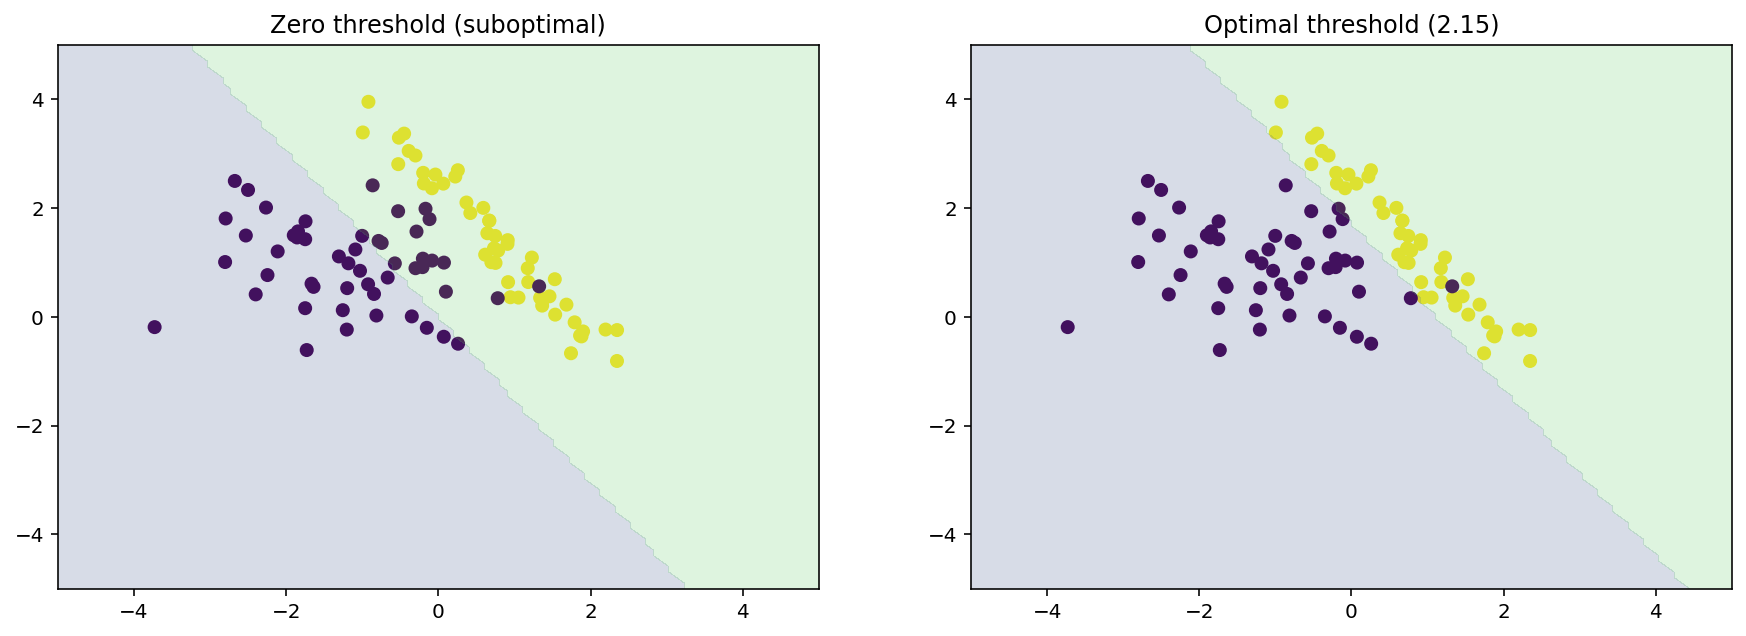

In [6]:
model = FisherLinearDiscriminant()
model.fit(x_train, t)
optimal_threshold = model._threshold

plt.figure(figsize=(15, 5))

# predict classes using the optimal threshold
predicted = model.predict(x_test)

plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(N, N), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.title(f"Optimal threshold ({round(optimal_threshold, 2)})")

# set threshold to zero and make predictions
model._threshold = 0
predicted = model.predict(x_test)

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=t)
plt.contourf(x1, x2, predicted.reshape(N, N), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.title("Zero threshold (suboptimal)")

plt.show()

### 4.1.7 The perceptron algorithm